# Libraries

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nltk
import re

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

from collections import defaultdict

from wordcloud import WordCloud

from transformers import pipeline, GPT2LMHeadModel, GPT2Tokenizer, Trainer, TrainingArguments

from datasets import Dataset

nltk.download ('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\handw\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\handw\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\handw\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\handw\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\handw\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Load Dataset

In [3]:
newsgroups_data = fetch_20newsgroups(subset='train', remove=('headers','footers','quotes'))

df = pd.DataFrame({
    'text':newsgroups_data.data,
    'category':newsgroups_data.target
})

df['category_name'] = df['category'].apply(lambda x: newsgroups_data.target_names[x])


In [4]:
df.head()

text  category  \
0  I was wondering if anyone out there could enli...         7   
1  A fair number of brave souls who upgraded thei...         4   
2  well folks, my mac plus finally gave up the gh...         4   
3  \nDo you have Weitek's address/phone number?  ...         1   
4  From article <C5owCB.n3p@world.std.com>, by to...        14   

           category_name  
0              rec.autos  
1  comp.sys.mac.hardware  
2  comp.sys.mac.hardware  
3          comp.graphics  
4              sci.space

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11314 entries, 0 to 11313
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   text           11314 non-null  object
 1   category       11314 non-null  int32 
 2   category_name  11314 non-null  object
dtypes: int32(1), object(2)
memory usage: 221.1+ KB


In [6]:
duplicates = df.duplicated(subset=['text']).sum()
print (f"number of duplicate rows: {duplicates}")

df = df.drop_duplicates(subset=['text'], keep='first').reset_index(drop=True)
print (f"Number of duplicate rows after removal: {df.duplicated(subset=['text']).sum()}")

number of duplicate rows: 320
Number of duplicate rows after removal: 0


In [7]:
df['category_name'].value_counts()

soc.religion.christian      592
rec.sport.hockey            585
sci.crypt                   582
rec.motorcycles             581
comp.windows.x              581
sci.med                     577
comp.sys.ibm.pc.hardware    577
sci.space                   576
rec.sport.baseball          575
sci.electronics             573
misc.forsale                572
comp.graphics               569
comp.os.ms-windows.misc     567
rec.autos                   563
comp.sys.mac.hardware       559
talk.politics.mideast       549
talk.politics.guns          533
alt.atheism                 469
talk.politics.misc          453
talk.religion.misc          361
Name: category_name, dtype: int64

# Level 1 : The Language Kingdom’s Gateway – Understanding the Terrain

count    10994.000000
mean      1251.595870
std       4091.494705
min          0.000000
25%        253.000000
50%        506.000000
75%       1009.000000
max      74878.000000
Name: text_length, dtype: float64


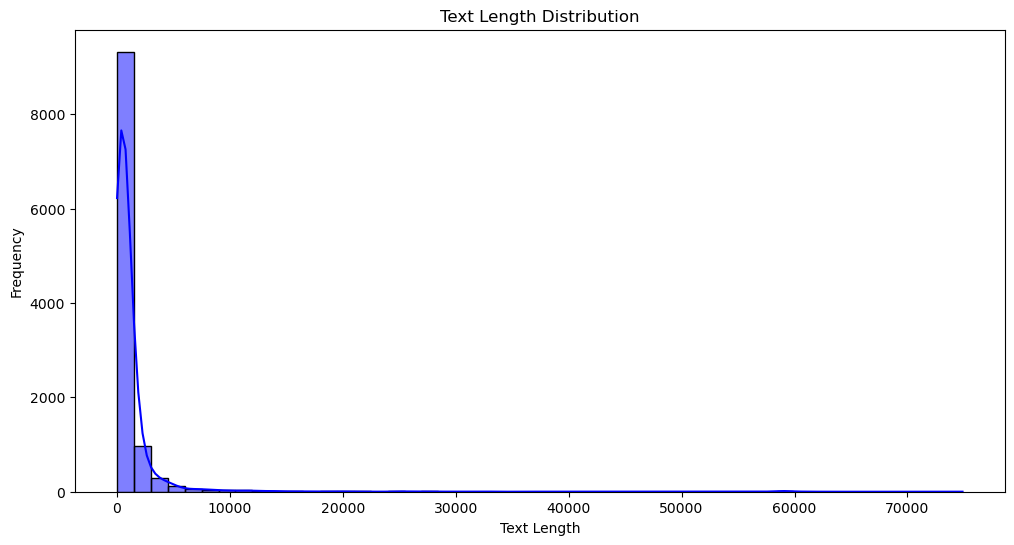

In [8]:
# calculate text length
df['text_length'] = df['text'].apply(len)
print (df['text_length'].describe())

# plot histogram
plt.figure(figsize=(12, 6))
sns.histplot(df['text_length'], bins=50, kde=True, color='blue')
plt.title('Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

- **Overall Text Length** : The average text length is around 1252 characters, with a standard deviation of 4091 characters. This indicates a wider range of text lengths in our data. There are some very short texts (minimuim length is 0 characters) and some very long texts (maximum length is 74878 characters)
- **Distribution Shape** : This histogram suggests a right-skewed distribution. The majority of the texts are likely shorter than the average length, with a tail extending towards longer texts.

In [9]:
#remove 0 characters from dataset
df = df[df['text_length'] > 0]. reset_index(drop=True)

In [10]:
print(df.columns)

Index(['text', 'category', 'category_name', 'text_length'], dtype='object')


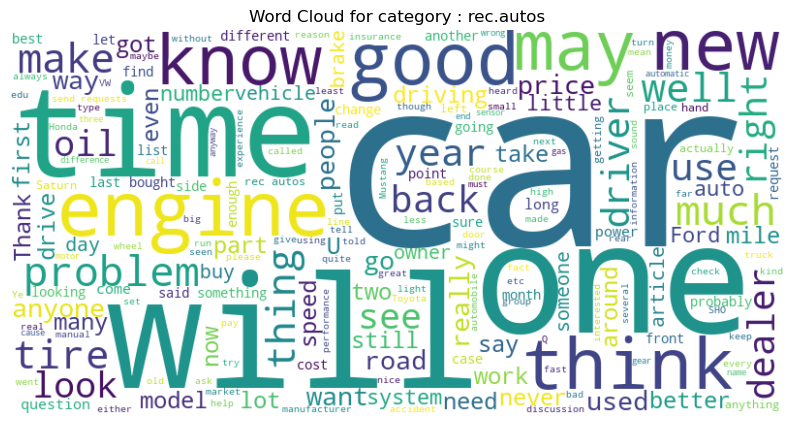

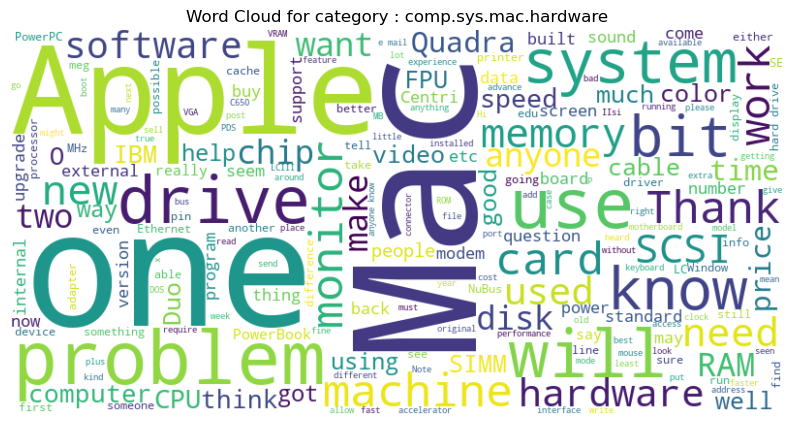

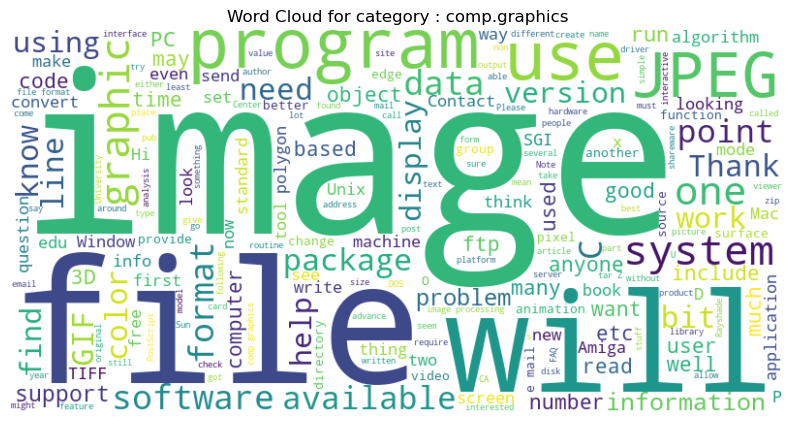

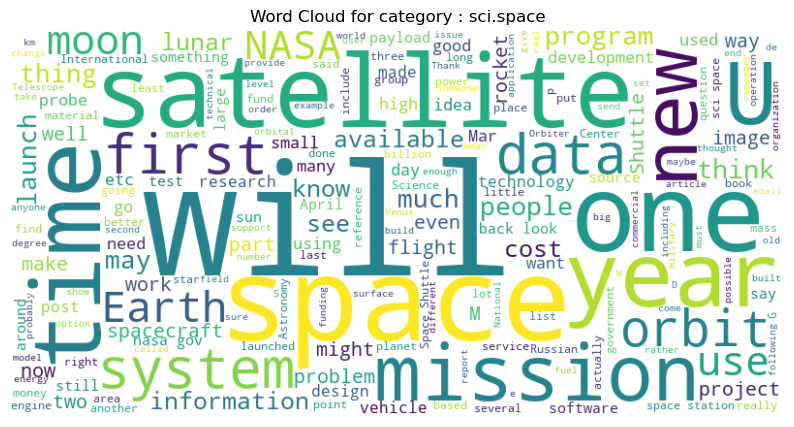

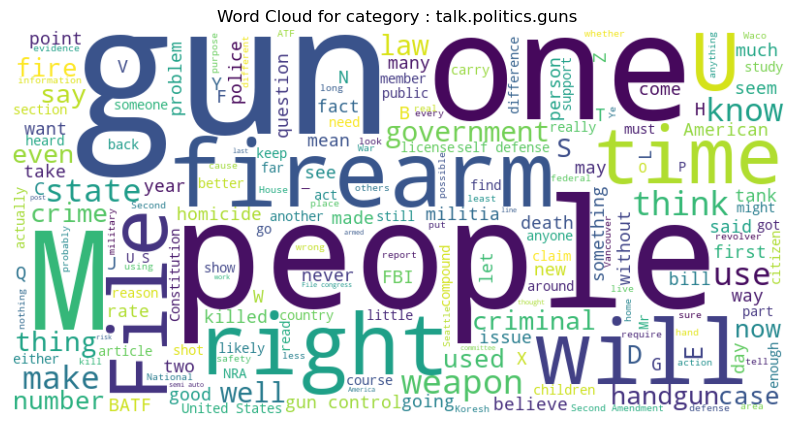

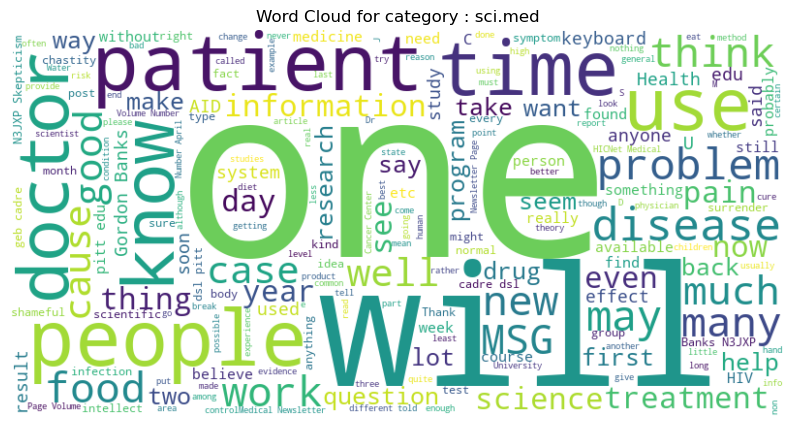

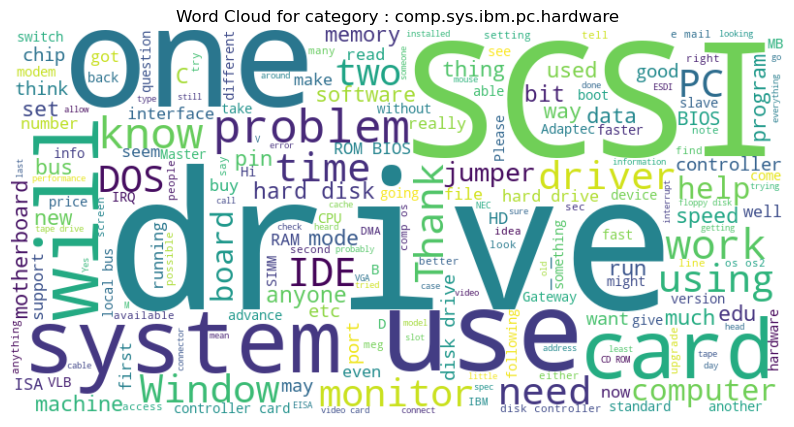

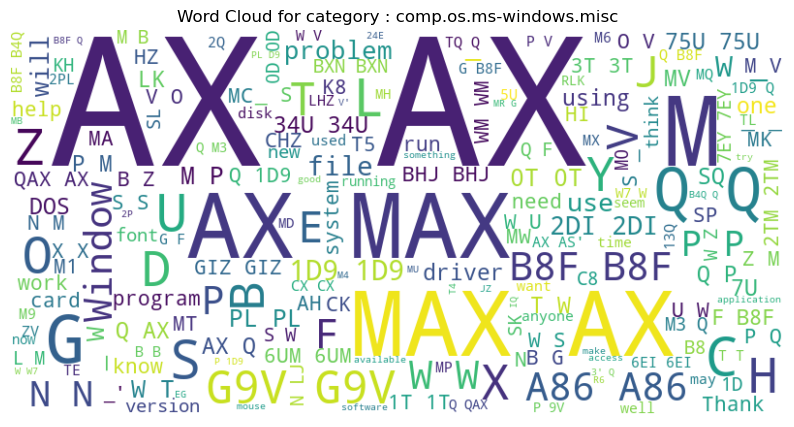

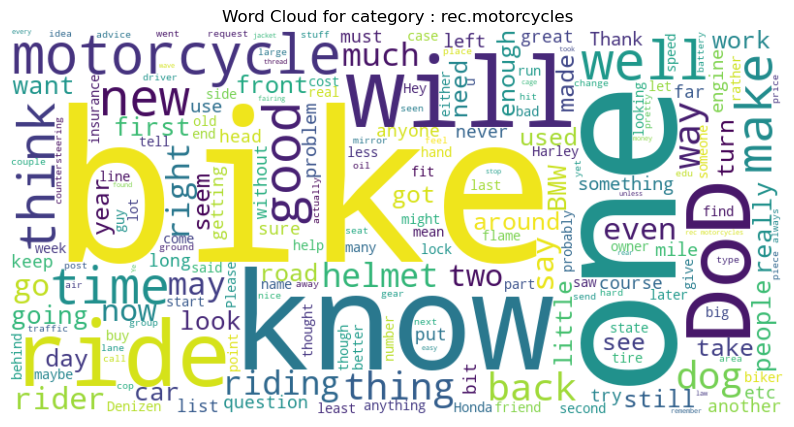

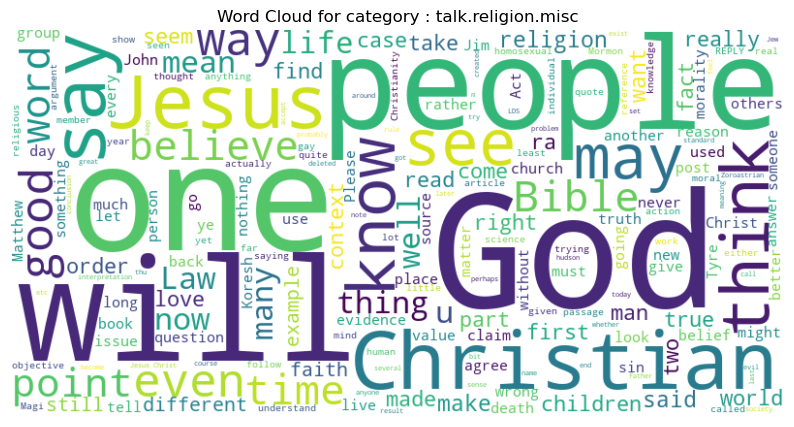

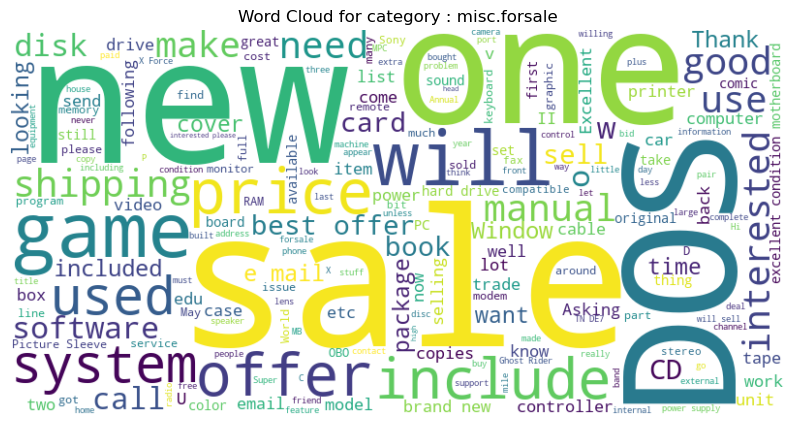

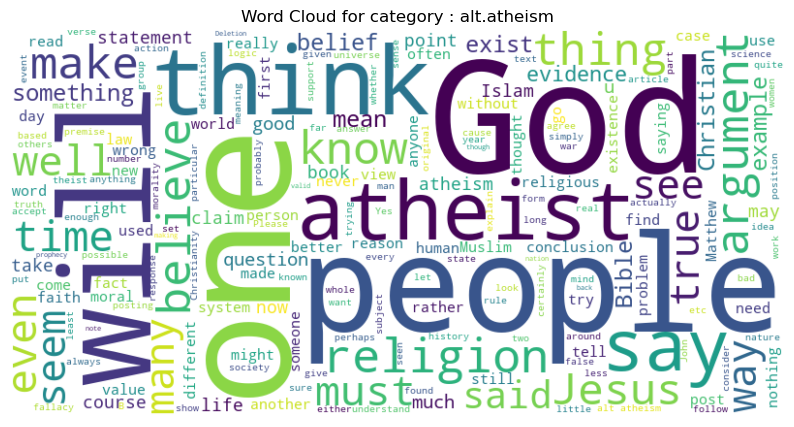

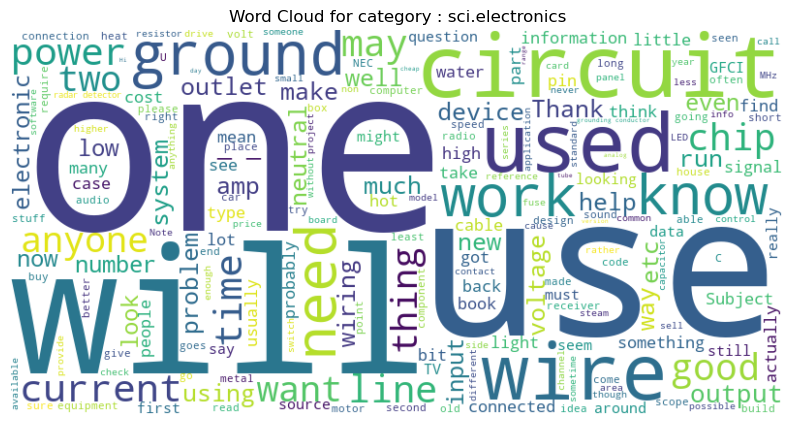

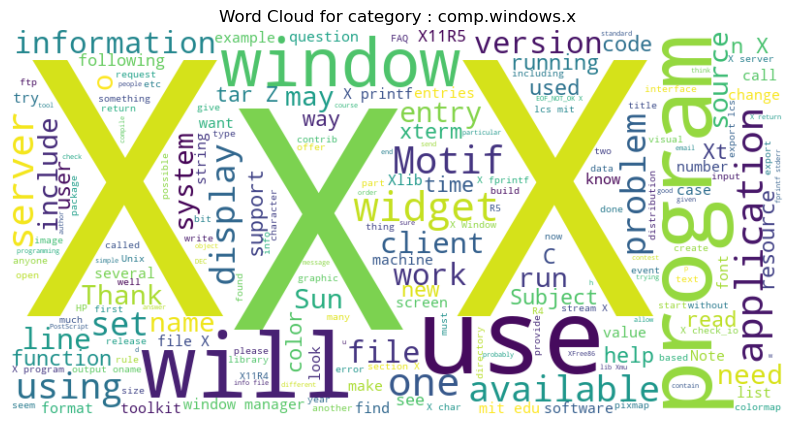

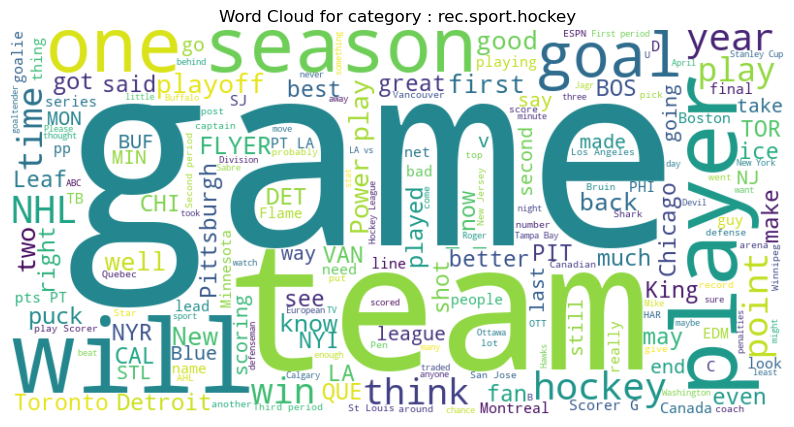

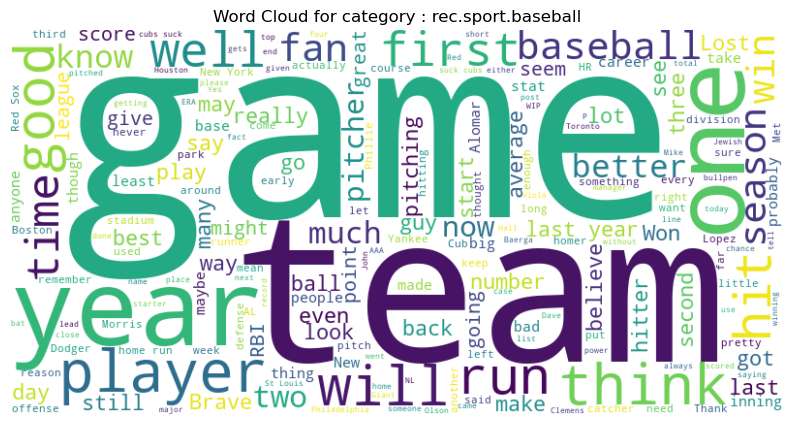

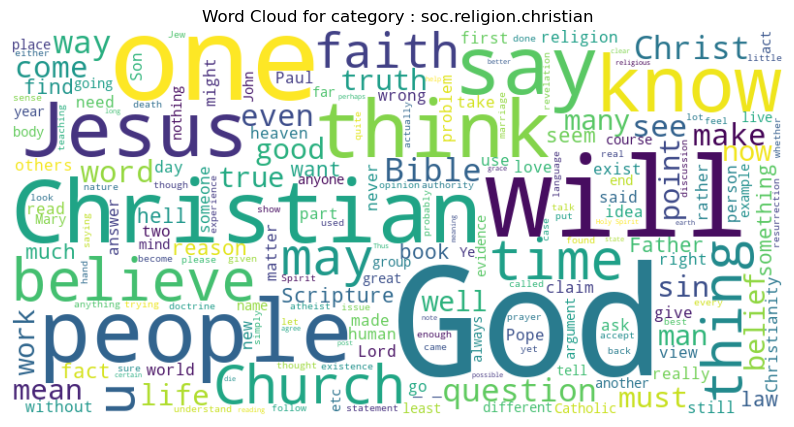

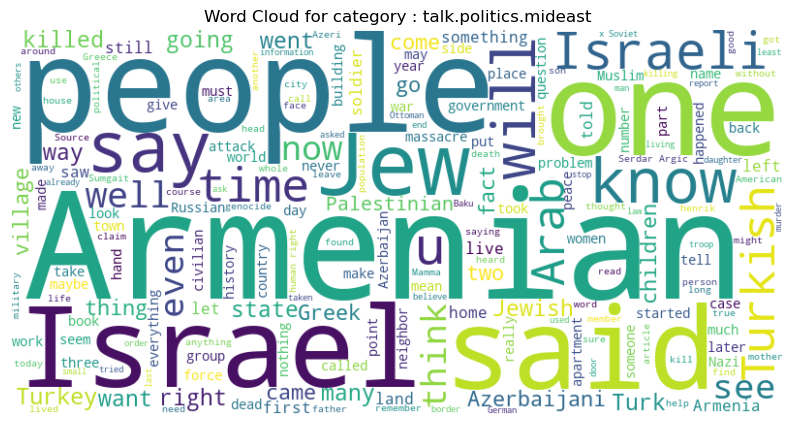

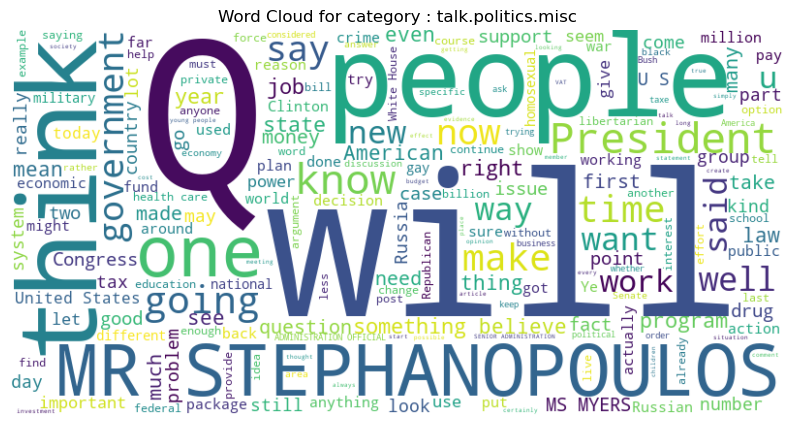

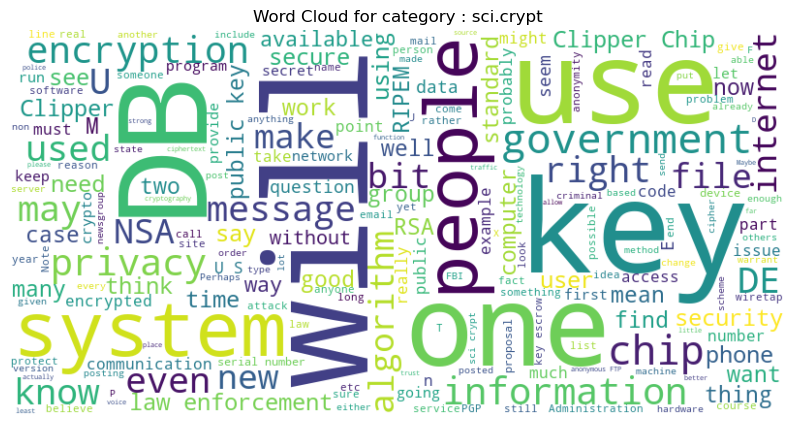

In [11]:
#Get unique categories in the dataset
categories = df['category_name'].unique()

# Wordcloud for each classes
for category in categories:
    category_text = ' '.join(df[df['category_name'] == category]['text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(category_text)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for category : {category}")
    plt.show()


### Insight

1. rec.autos:
- Focuses on discussions about cars, driving, and automotive maintenance.
- Common topics include buying and selling cars, car repairs, driving experiences, and vehicle specifications.
2. comp.sys.mac.hardware:
- Primarily centered around Apple Macintosh computers and their hardware components.
- Discussions often involve troubleshooting, hardware compatibility issues, and experiences with different hardware components.
3. comp.graphics:
- Focuses on computer graphics, image processing, and related software.
- Key topics include image formats, software tools, 3D graphics, and data visualization.
4. sci.space:
- Primarily dedicated to space exploration, astronomy, and related technologies.
- Common discussions involve space missions, satellites, rockets, planets, and NASA.
5. talk.politics.guns:
- Focuses on gun control, gun violence, and the Second Amendment.
- Discussions often center on gun laws, mass shootings, self-defense, and gun rights.
6. sci.med:
- Centers around medical science, health, and diseases.
- Common topics include medical research, patient experiences, treatments, and drug information.
7. comp.sys.ibm.pc.hardware:
- Focuses on discussions about IBM PC hardware and related components.
- Users often discuss hard drives, memory, motherboards, controllers, and DOS-related topics.
- Troubleshooting and hardware performance optimization are also frequently addressed.
8. comp.os.ms-windows.misc:
- Focuses on Microsoft Windows operating systems and related software.
- Common topics include Windows versions, software compatibility, driver issues, troubleshooting, and usage tips.
9. rec.motorcycles:
- Focuses on motorcycles, riding experiences, and motorcycle maintenance.
- Topics include motorcycle brands, models, repairs, road trips, and safety tips.
10. talk.religion.misc:
- Centers on religion, faith, and spirituality.
- Common topics include God, Jesus, the Bible, belief, faith, and morality.
11. misc.forsale:
- Focuses on buying, selling, and trading various items.
- Common topics include electronics, computer hardware, books, games, and personal items.
12. alt.atheism:
- Focuses on atheism, religion, and spirituality.
- Discussions often involve God, religion, belief, faith, and the debate between atheism and Christianity, as well as philosophical and scientific topics.
13. sci.electronics:
- Focuses on electronics and electrical engineering.
- Key topics include circuits, components, power, signals, and troubleshooting.
- Users often discuss building electronic projects and repairing electronic devices.
14. comp.windows.x:
- Focused on the X Windows system, a windowing system for Unix-like operating systems.
- Common topics include X server configuration, window managers, applications, and programming with X libraries.
15. rec.sport.hockey:
- Centers on ice hockey discussions.
- Common topics include NHL teams, players, games, scores, playoffs, strategies, and game analysis.
16. rec.sport.baseball:
- Primarily focused on baseball discussions.
- Topics include teams, players, games, scores, statistics, strategies, and game analysis.
17. soc.religion.christian:
- Focuses on discussions about Christianity and Christian beliefs.
- Topics include God, Jesus, the Bible, faith, morality, and the role of religion in daily life.
18. talk.politics.mideast:
- Primarily focused on discussions about the Middle East, particularly the Israeli-Palestinian conflict and related geopolitical issues.
- Common topics include Israel, Palestine, Arabs, Jews, war, peace, human rights, political ideologies, and international relations.
19. talk.politics.misc:
- Focused on US politics.
- Topics include government, elections, politicians, current events, social issues, and economic policies.
20. sci.crypt:
- Focuses on cryptography and security.
- Common topics include encryption, algorithms, security protocols, privacy, and the ethical implications of cryptography.
----------------------------------------------
The analyzed newsgroups exhibit a diverse range of topics, spanning technology, science, sports, politics, religion, and miscellaneous discussions:

- "comp" newsgroups (e.g., "comp.sys.mac.hardware," "comp.graphics") focus on technical discussions related to hardware, software, and computing.
- "sci" newsgroups (e.g., "sci.space," "sci.med") delve into scientific subjects, including space exploration, medicine, and electronics.
- "rec" newsgroups (e.g., "rec.sport.hockey," "rec.motorcycles") are centered around recreational interests, particularly sports and hobbies.
- "talk" newsgroups (e.g., "talk.politics.misc," "talk.religion.misc") are engaged in debates and discussions on political and religious issues.
- Miscellaneous newsgroups (e.g., "misc.forsale," "alt.atheism") cover topics ranging from classified ads to philosophical debates.  

Each of these categories reveals a unique set of topics and discussions, reflecting the broad spectrum of interests and concerns within the newsgroups.

----------------

# Level 2: Power-Ups & Secret Moves – Building NLP Pipelines

In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

custom_stopwords = {'db', 'di', 'tm', 'pl', 'cx', 'wm', 'ei', 'um', 'bhj', 'giz', 'ax'}
bigram_stopwords = {'db db', 'di di', 'tm tm', 'pl pl', 'cx cx', 'wm wm', 'ei ei', 'um um', 'bhj bhj', 'giz giz'}

def get_wordnet_pos(tag):
    """
    Maps a Penn Treebank part-of-speech (POS) tag to a WordNet-compatible POS tag.

    Parameters:
        tag (str): The Penn Treebank POS tag (e.g., 'JJ', 'VB', 'NN', 'RB').

    Returns:
        wordnet.POS: The corresponding WordNet POS tag for lemmatization. If no match is found,
                     defaults to `wordnet.NOUN`.
                     
    Mapping:
        - Tags starting with 'J' (adjective) -> `wordnet.ADJ`
        - Tags starting with 'V' (verb) -> `wordnet.VERB`
        - Tags starting with 'N' (noun) -> `wordnet.NOUN`
        - Tags starting with 'R' (adverb) -> `wordnet.ADV`
        - Any other tag defaults to `wordnet.NOUN`
    """
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
def preprocess_text(text):
    """
    Preprocesses the input text by cleaning, normalizing, and tokenizing it for further NLP tasks.

    Parameters:
        text (str): The raw text to preprocess.

    Returns:
        str: The cleaned and preprocessed text, with stopwords removed, lemmatization applied, 
             and extraneous characters or patterns cleaned.

    Steps:
        1. Removes specific bigram stopwords using a predefined list (`bigram_stopwords`).
        2. Cleans unwanted patterns such as repeated characters (e.g., "ax>" and excessive repetitions).
        3. Removes all non-alphabetic characters.
        4. Tokenizes the text and converts it to lowercase.
        5. Applies part-of-speech tagging and lemmatizes tokens using WordNet POS tags.
        6. Filters out stopwords and short tokens (length ≤ 1).
        7. Joins the processed tokens back into a single string.

    Notes:
        - Relies on external objects such as `bigram_stopwords`, `stop_words`, and `lemmatizer`.
        - The `get_wordnet_pos` helper function is used to map POS tags to WordNet-compatible tags.
        - Assumes the input text is in English.
    """
    for bigram in bigram_stopwords:
        text = re.sub(rf'\b{bigram}\b', '', text, flags=re.IGNORECASE)

    text = re.sub(r'(ax>)+', ' ', text, flags=re.IGNORECASE)
    text = re.sub (r'[^a-zA-Z]', ' ', text)
    text = re.sub(r'(.)\1{2,}', r'\1', text)

    tokens = word_tokenize(text.lower())
    post_tags = pos_tag(tokens)
    
    tokens = [
        lemmatizer.lemmatize(word, get_wordnet_pos(tag))
        for word, tag in post_tags
        if word not in stop_words and len(word) > 1
    ]
    return " ".join(tokens)

df['cleaned_text'] = df['text'].apply(preprocess_text)
df[['category_name', 'text','cleaned_text']].head()

category_name                                               text  \
0              rec.autos  I was wondering if anyone out there could enli...   
1  comp.sys.mac.hardware  A fair number of brave souls who upgraded thei...   
2  comp.sys.mac.hardware  well folks, my mac plus finally gave up the gh...   
3          comp.graphics  \nDo you have Weitek's address/phone number?  ...   
4              sci.space  From article <C5owCB.n3p@world.std.com>, by to...   

                                        cleaned_text  
0  wonder anyone could enlighten car saw day door...  
1  fair number brave soul upgrade si clock oscill...  
2  well folk mac plus finally give ghost weekend ...  
3  weitek address phone number like get informati...  
4  article owcb world std com tombaker world std ...

**Text Preprocessing**
* **Stopwords Removal**
    * **Standard stopwords** were removed using NLTK stopwords corpus, which included commen English words that do not carry significant meaning.
    * **Custom stopwords** were defined based on the dataset, filtering out terms that may be irrelevant or too specific to the context
    * **Bigram stopwords** like ("db db", or "di di") were removed to avoid repetitive patterns that do not add value to analysis
* **Text Cleaning**
    * Applied **regex-based cleaning** to remove unwanted characters and symbols such as "ax>".
    * Addressed **redundant Characters** (e.g., "looooong" converted into "long").
    * Removed **non-alphabetical characters** and unnecessary symbols

============================================================================================================================================================

In [13]:
vectorizer = CountVectorizer(max_features=50)
X = vectorizer.fit_transform(df['cleaned_text'])
word_frequencies = pd.DataFrame({
    'Word': vectorizer.get_feature_names_out(),
    'Frequency': X.toarray().sum(axis=0)
}).sort_values(by='Frequency', ascending=False)

print ('\nTop words :')
print (word_frequencies)


Top words :
        Word  Frequency
42       use       6782
25       one       6759
48     would       6157
10       get       5831
33       say       4786
16      know       4563
19      make       4227
26    people       4130
12        go       4104
17      like       4057
38     think       3866
39      time       3679
0       also       3348
14      good       3312
34       see       3034
45      well       2912
47      work       2860
49      year       2844
24       new       2702
36      take       2685
35    system       2656
7       file       2620
3      could       2535
2       come       2436
5        edu       2422
43      want       2420
21       may       2415
18      look       2353
6       even       2327
31     right       2326
28   problem       2308
11      give       2297
23      need       2292
8       find       2286
37     thing       2276
44       way       2270
41       two       2237
9      first       2225
22      much       2099
20      many       2098
29 

In [14]:
bigram_vectorizer = CountVectorizer(max_features=50, ngram_range=(2, 2))
bigram_X = bigram_vectorizer.fit_transform(df['cleaned_text'])

bigram_frequencies = pd.DataFrame({
    'Bigram': bigram_vectorizer.get_feature_names_out(),
    'Frequency':bigram_X.toarray().sum(axis=0)
}).sort_values(by='Frequency', ascending=False)

bigram_frequencies = bigram_frequencies[~bigram_frequencies['Bigram'].isin(bigram_stopwords)]

print ("\nTop Bigrams: ")
print (bigram_frequencies)


Top Bigrams: 
               Bigram  Frequency
47         would like        430
26  mr stephanopoulos        341
2         anyone know        303
43       united state        298
28           new york        287
21          look like        271
18          last year        269
48           year ago        259
19    law enforcement        228
39     thanks advance        225
37     something like        219
25            mit edu        205
0       anonymous ftp        203
49           year old        199
24        many people        196
5        clipper chip        195
17         hard drive        186
23          make sure        179
22        los angeles        169
38         sound like        162
16          hard disk        161
11        even though        160
20           let know        154
1     answer question        153
33         public key        152
32         power play        148
29          one thing        145
27           nasa gov        141
15        gun control       

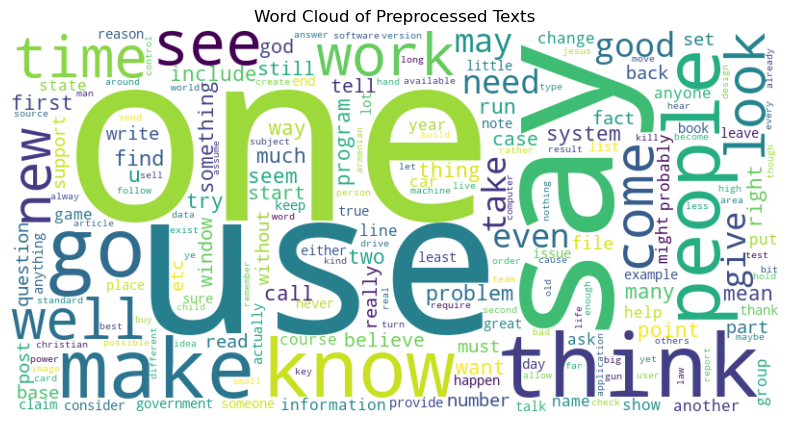

In [15]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(df['cleaned_text']))
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Preprocessed Texts')
plt.show()

In [16]:
#capture keyword from the text
tfidf_vectorizer = TfidfVectorizer(max_features=50)

X_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_text'])

tfidf_id = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

tfidf_words = pd.DataFrame({
    'Word':tfidf_vectorizer.get_feature_names_out(),
    'TF-IDF Score': X_tfidf.toarray().sum(axis=0)
}).sort_values(by='TF-IDF Score', ascending=False)

print ("\nTop TF-IDF Words:")
print (tfidf_words)


Top TF-IDF Words:
        Word  TF-IDF Score
48     would    943.555094
42       use    921.822990
25       one    915.974534
10       get    908.208407
16      know    767.478958
17      like    702.905525
38     think    663.510956
19      make    651.370529
33       say    643.033799
12        go    618.923175
26    people    576.477567
14      good    576.218074
39      time    551.896104
0       also    516.417879
34       see    502.563015
3      could    495.495752
49      year    488.901999
45      well    488.518764
18      look    482.482598
47      work    477.085010
24       new    470.317767
43      want    444.695979
23      need    438.171605
36      take    437.840433
28   problem    430.148317
5        edu    419.356676
8       find    414.886881
22      much    411.024597
35    system    406.110930
31     right    404.376289
2       come    403.587419
6       even    400.499052
37     thing    396.438810
40       try    395.386822
11      give    391.264660
44       

**Keyword Extraction**
* **CountVectorizer** : we used this to extract unigrams (single words) and generated the top 50 most frequent terms in the dataset. This step is essential for understanding the core vocabulary used in the text
* **Bigram Extraction** : A **CountVectorizer** was also employed with a bigram range to identify the most frequent two-word combinations in the dataset
* **TF-IDF** : Applied **TfidfVectorizer** to capture the importance of words in relation to their frequency across documents, with a focus on the top 50 terms. This helps priorize words that are more relevant for understanding context and meaning

============================================================================================================================================================

In [ ]:
ner_pipeline = pipeline("ner", model="dbmdz/bert-large-cased-finetuned-conll03-english")

def extract_entities(text):
    """
    Extracts named entities from the input text using a pretrained NER model.

    Parameters:
        text (str): The input text from which entities are to be extracted.

    Returns:
        list of tuples: A list of tuples where each tuple contains:
                        - The entity word (str)
                        - The entity label (str) as identified by the NER model.

    Notes:
        - This function uses a named entity recognition (NER) pipeline to process the text.
        - The entity labels typically follow the IOB2 format (e.g., "B-PER" for the beginning of a person's name).
    """
    entities = ner_pipeline(text)
    return [(entity['word'], entity['entity']) for entity in entities]

df['ner_entities'] = df['text'].apply(extract_entities)

print ("\nNamed Entities:")
print (df[['text', 'ner_entities']])


Named Entities:
                                                    text  \
0      I was wondering if anyone out there could enli...   
1      A fair number of brave souls who upgraded thei...   
2      well folks, my mac plus finally gave up the gh...   
3      \nDo you have Weitek's address/phone number?  ...   
4      From article <C5owCB.n3p@world.std.com>, by to...   
...                                                  ...   
10988  DN> From: nyeda@cnsvax.uwec.edu (David Nye)\nD...   
10989  I have a (very old) Mac 512k and a Mac Plus, b...   
10990  I just installed a DX2-66 CPU in a clone mothe...   
10991  \nWouldn't this require a hyper-sphere.  In 3-...   
10992  Stolen from Pasadena between 4:30 and 6:30 pm ...   

                                            ner_entities  
0                     [(Brick, I-MISC), (##lin, I-MISC)]  
1                                          [(S, I-MISC)]  
2      [(Tom, I-ORG), (Willis, I-ORG), (Purdue, I-ORG...  
3            [(Wei, I-ORG)

In [ ]:
#pre-processing the result 
def preprocess_entities(ner_entities):
    """
    Processes a list of named entity recognition (NER) token-entity pairs to group 
    and deduplicate entities by their types.

    Parameters:
        ner_entities (list of tuple): A list of tuples, where each tuple contains:
            - token (str): A word or subword token from the text.
            - entity_type (str): The NER tag associated with the token, e.g., 'I-PER', 'B-ORG'.

    Returns:
        dict: A dictionary where the keys are entity types (e.g., 'PER', 'ORG', 'LOC'), 
              and the values are lists of unique entities belonging to each type.

    Example:
        Input: [("Tom", "I-PER"), ("Willis", "I-PER"), ("Purdue", "I-ORG"), ("University", "I-ORG")]
        Output: {'PER': ['Tom Willis'], 'ORG': ['Purdue University']}
    """
    entity_dict = defaultdict(list)
    current_entity = ""
    current_type = None

    for token, entity_type in ner_entities:
        if token.startswith("##"):
            current_entity += token[2:]
        else:
            if current_entity and current_type:
                entity_dict[current_type].append(current_entity.strip())
            current_entity = token
            current_type = entity_type.split("-")[-1]
    if current_entity and current_type:
        entity_dict[current_type].append(current_entity.strip())

    for entity_type in entity_dict:
        entity_dict[entity_type] = list(set(entity_dict[entity_type]))

    return dict(entity_dict)

print ("Original NER Entities:")
print (df['ner_entities'])

df['processed_entities'] = df['ner_entities'].apply(preprocess_entities)

print ("\nProcessed NER entities:")
print (df[['text','processed_entities']])

Original NER Entities:
0                       [(Brick, I-MISC), (##lin, I-MISC)]
1                                            [(S, I-MISC)]
2        [(Tom, I-ORG), (Willis, I-ORG), (Purdue, I-ORG...
3              [(Wei, I-ORG), (##te, I-ORG), (##k, I-ORG)]
4               [(Tom, I-PER), (A, I-PER), (Baker, I-PER)]
                               ...                        
10988    [(David, I-PER), (N, I-PER), (##ye, I-PER), (E...
10989    [(Mac, I-MISC), (Mac, I-MISC), (Plus, I-MISC),...
10990    [(D, I-MISC), (##X, I-MISC), (##2, I-MISC), (6...
10991                                                   []
10992    [(Pasadena, I-LOC), (Honda, I-ORG), (CB, I-MIS...
Name: ner_entities, Length: 10993, dtype: object

Processed NER entities:
                                                    text  \
0      I was wondering if anyone out there could enli...   
1      A fair number of brave souls who upgraded thei...   
2      well folks, my mac plus finally gave up the gh...   
3      \nDo yo

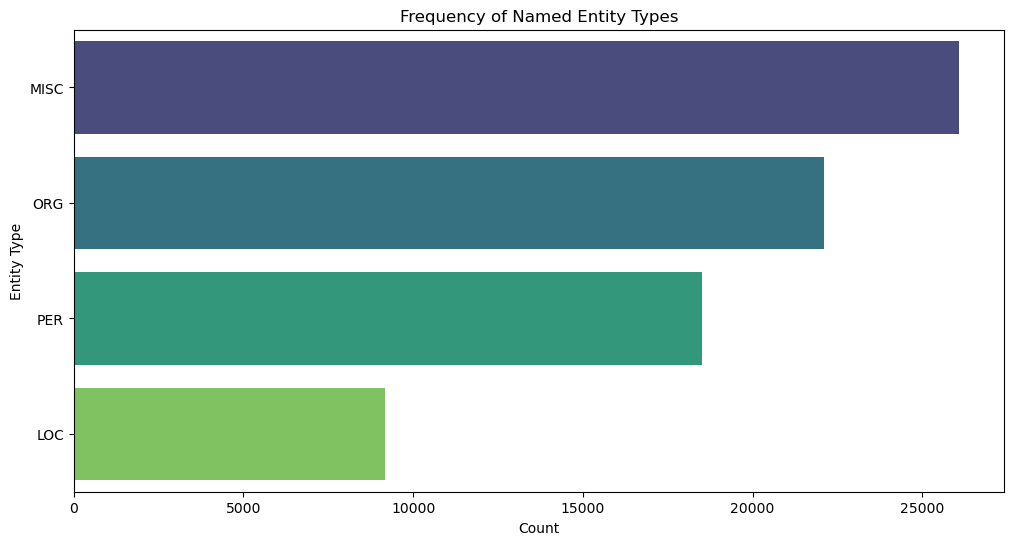

In [19]:
#visualize the result
entity_counts = defaultdict(int)

for entity_dict in df['processed_entities']:
    for entity_type in entity_dict:
        entity_counts[entity_type] += len(entity_dict[entity_type])

entity_df = pd.DataFrame(entity_counts.items(), columns=['Entity Type','Count'])

entity_df = entity_df.sort_values(by='Count', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x='Count', y='Entity Type', data=entity_df, palette='viridis')
plt.title('Frequency of Named Entity Types')
plt.xlabel('Count')
plt.ylabel('Entity Type')
plt.show()

### Insight NER Result

**Insight from visualization**
1. **MISC (Miscellaneous)**: This entity type has the highest frequency, suggesting that a large portion of the text in our dataset contains miscellaneous entities. These might include less common or broader categories of entities that don't fit neatly into the usual types like personanames or organizations.
2. **ORG (Organizations)**: The second moset frequent entity is "ORG", indicating that organizations or companies are a significant focus in our dataset. This might reflect the context or subject matter of the text, which could involve business, institutions, or corporate references.
3. **PER (Persons)**: "PER" entities (representing people) are also frequent, but not as much as organizations. This could indicat that our dataset contains a notable amount of mentions of individuals, either in the form of names or personal references.
4. **LOC (Locations)**: "LOC" entities, referring to locations, are the least frequent among the primary categories shown here. This suggests that location mentions in the text may not be as prevalent, possibly because the text focuses more on abstract entities like organizations or people rather than specific geographic locations.

**General Observations :**
* **Miscellaneous** Entities dominate, which might imply a diverse range of entities being mentioned in the text, not necessarily bound by the traditional NER categories.
* The prominence of **organizations** and **persons** further emphasizes that the text likely revolves around topics involving business or individual figures.
* **Locations** appearing less frequently might indicate that the text does not focus on geographical contexts, or it could mean that locations are not the key entities in the dataset's content.

**Named Entity Recognition (NER)**
* **NER Pipeline** : A pre-trained model (dbmdz/bert-large-cased-finetuned-con1103-english) was used to detect and classify named entities in the text, such as people, organizations, and locations.
* **Entity Processing** : I'm extracting the entities and categorized them into four types : **PER** (Person), **ORG** (Organization), **LOC** (Location), and **MISC** (Miscellaneous). Then visualized these entity types
* **Entity Insight** : After extracting entities, I Grouped them by type, cleaned up any duplicates, and presented a summary of the most frequenet entities across the dataset

In [20]:
# Sentiment Analysis
sentiment_pipeline = pipeline("sentiment-analysis", model='distilbert-base-uncased-finetuned-sst-2-english')

def get_sentiment(text, max_length=512):
    """
    Analyzes the sentiment of a given text using a pre-defined sentiment analysis pipeline.

    Parameters:
        text (str): The input text to analyze.
        max_length (int, optional): The maximum number of characters to consider for analysis.
            Defaults to 512. The text will be truncated to this length if it exceeds the limit.

    Returns:
        dict: A dictionary containing the sentiment analysis results, including the label 
              (e.g., 'positive', 'negative') and the corresponding confidence score.
    """
    truncated_text = text[:max_length]
    sentiment = sentiment_pipeline(truncated_text)

    return sentiment

df['sentiment'] = df['cleaned_text'].apply(lambda x: get_sentiment(x))
df.head()

text  category  \
0  I was wondering if anyone out there could enli...         7   
1  A fair number of brave souls who upgraded thei...         4   
2  well folks, my mac plus finally gave up the gh...         4   
3  \nDo you have Weitek's address/phone number?  ...         1   
4  From article <C5owCB.n3p@world.std.com>, by to...        14   

           category_name  text_length  \
0              rec.autos          475   
1  comp.sys.mac.hardware          530   
2  comp.sys.mac.hardware         1659   
3          comp.graphics           95   
4              sci.space          448   

                                        cleaned_text  \
0  wonder anyone could enlighten car saw day door...   
1  fair number brave soul upgrade si clock oscill...   
2  well folk mac plus finally give ghost weekend ...   
3  weitek address phone number like get informati...   
4  article owcb world std com tombaker world std ...   

                                        ner_entities  \
0                 [(Brick, I-MISC), (##lin, I-MISC)]   
1                                      [(S, I-MISC)]   
2  [(Tom, I-ORG), (Willis, I-ORG), (Purdue, I-ORG...   
3        [(Wei, I-ORG), (##te, I-ORG), (##k, I-ORG)]   
4         [(Tom, I-PER), (A, I-PER), (Baker, I-PER)]   

                                  processed_entities  \
0                             {'MISC': ['Bricklin']}   
1                                    {'MISC': ['S']}   
2  {'ORG': ['Electrical', 'Purdue', 'Tom', 'Willi...   
3                                {'ORG': ['Weitek']}   
4                     {'PER': ['A', 'Baker', 'Tom']}   

                                           sentiment  
0  [{'label': 'NEGATIVE', 'score': 0.840516686439...  
1  [{'label': 'NEGATIVE', 'score': 0.952669560909...  
2  [{'label': 'POSITIVE', 'score': 0.675776481628...  
3  [{'label': 'NEGATIVE', 'score': 0.967867493629...  
4  [{'label': 'NEGATIVE', 'score': 0.998776137828...

<AxesSubplot:title={'center':'Sentiment Distribution'}>

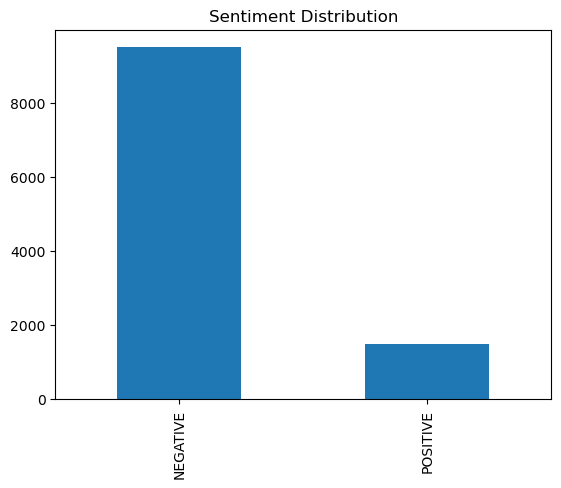

In [21]:
sentiment_counts = df['sentiment'].apply(lambda x: x[0]['label']).value_counts()

sentiment_counts.plot(kind='bar', title='Sentiment Distribution')

Sentiment distribution plot indicates a strong negative sentiment bias in our dataset. This means that the majority of the text data expresses negative opinions or emotions. This bias could be due to the dataset's origin or the topics it covers.

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10993 entries, 0 to 10992
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   text                10993 non-null  object
 1   category            10993 non-null  int32 
 2   category_name       10993 non-null  object
 3   text_length         10993 non-null  int64 
 4   cleaned_text        10993 non-null  object
 5   ner_entities        10993 non-null  object
 6   processed_entities  10993 non-null  object
 7   sentiment           10993 non-null  object
dtypes: int32(1), int64(1), object(6)
memory usage: 644.2+ KB


# Level 3: The Generative Vault – Creating New Content with AI

In [ ]:
df_gpt = df[['cleaned_text']]

dataset = Dataset.from_pandas(df_gpt)

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

tokenizer.pad_token = tokenizer.eos_token 

def tokenize_function(examples):
    """
    Tokenizes text data for input into a pretrained transformer model.

    Parameters:
        examples (dict): A dictionary containing a key `'cleaned_text'`, where the value is a list of strings 
                         representing preprocessed text data to be tokenized.

    Returns:
        dict: A dictionary containing tokenized outputs, including token IDs, attention masks, 
              and other relevant fields, formatted for input into a transformer model.

    Notes:
        - The tokenizer applies padding to ensure all sequences have the same length.
        - Text is truncated to a maximum length of 512 tokens.
        - This function is typically used in conjunction with a `Dataset` object in NLP pipelines.
    """
    return tokenizer(examples['cleaned_text'], padding='max_length', truncation=True, max_length=512)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

model = GPT2LMHeadModel.from_pretrained('gpt2', from_tf=True)

model.config.pad_token_id = tokenizer.pad_token_id 

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=4,
    save_steps=10_000,
    save_total_limit=2,    
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets,
)

prompt = "Breaking news in sports:"
input_ids = tokenizer(prompt, return_tensors='pt').input_ids
generated_ids = model.generate(input_ids, max_length=100, num_return_sequences=1, temperature=0.7, top_k=50, top_p=0.95, no_repeat_ngram_size=2)
generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

print("Generated Text:")
print(generated_text)



All TF 2.0 model weights were used when initializing GPT2LMHeadModel.

All the weights of GPT2LMHeadModel were initialized from the TF 2.0 model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GPT2LMHeadModel for predictions without further training.


Generated Text:
Breaking news in sports: Sign up for our morning blast HERE


In [24]:
prompt = "Latest trends in artificial intelligence:"

input_ids = tokenizer(prompt, return_tensors='pt').input_ids

generated_ids = model.generate(
    input_ids, 
    max_length=150,
    num_return_sequences=1, 
    temperature=1.0, 
    top_k=50,
    top_p=0.92, 
    no_repeat_ngram_size=2
)

generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

print("Generated Text:")
print(generated_text)

Generated Text:
Latest trends in artificial intelligence:

The number of people who are using artificial intelligences to solve problems has increased by more than 50% since the beginning of the year, according to a new report from the University of California, Berkeley.
...
 (The U.S. Department of Homeland Security has estimated that the number who use artificial intelligent systems to help solve crimes has risen by nearly 50 percent since 2014, and that this number is expected to continue to increase.)
, the U, has projected that artificial Intelligence will be used in the next five years to improve the quality of life of Americans. The report also predicts that by 2020, artificial AI will become the dominant technology in our lives. (See also: Artificial Intelligence:


### Insight Level 3

**What I did**
In this level, I worked on building a generative AI model that creates text based on the patterns in a dataset. To do this, I used the GPT-2 model, which is a popular language model known for generating human-like text. I started with a dataset that contained various topics like religion, sports, and politics. Using the pretrained GPT-2 model, i made it generate new text based on specific prompts I gave it.
Here's the process i followed : 
1. **Load The Dataset** : Dataset was fetch from  fetch_20newsgroups
2. **Prepared the text** : I cleaned and formatted the text so that GPT-2 could process it.
3. **Used the GPT-2 Model** : I didn't train a model from scratch but used a **pretrained GPT-2 model**, which helped me save time and focus on generating text instead of worrying about training a model
4. **Text Generation** : Once I set up the model, I provided different prompts related to various topics. The model then generated responses based on those prompts, creating new content related to the categories in my dataset.

**What the result looks like :**
The reulst was quite interesting. After providing specific prompts related to topics like "Artificial intelligence trends" or "sports updates", the model generated responses that fit the topic. The text generated was coherent for the most part, but at times it would repeat itself or stary slightly from the topic. Despite this, it generally provided relevant and useful content that could be further refined

**Pros of the model:**
1. **Creative Text Generation:** The GPT-2 model was able to generate diverse and original content based on the prompts I provided
2. **Topic Relevance:** The model understood the basic context of the prompts and generated responses related  to those topics, whether it was about sports, religion, or technology.
3. **Quick and Easy:** Using a pretrained model made it easy to generate text quickly. I didn't have to spend time training the model, which saved me a lot of effort.
4. **Scalable for Multiple Topics:** I could apply the model to different categories, making it flexible and adaptable for generating content on a variety of subjects.

**Cons of the model:**
1. **Repetitiveness:**One of the challenges I faced was that the model sometimes repeated phrases or sentences, which affected the quality of the text.
2. **Inconsistencies in Quality:** while some responses were coherent and relevant, others felt disjointed or off-topic, showing that the model isn't perfect at generating consistently high-quality text
3. **Limited Fine-Tuning:** Since I'm using a pretrained model without further training, there were areas where the model could be fine-tuned for better performance in certain categories.
4. **Potential Inaccuracies:** As expected with pretrained models, there were occasional inaccuaracies in the generated text, especially when handling more complex or specific topics